#Time Series Analysis and Forecasting

## 1. Import Libary

In [1]:
# %pip install pandas numpy matplot seaborn statsmodels

In [11]:
# import libary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Analysis Time Series Data
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Forcast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#Forecast Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import itertools
import warnings

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Import Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predict Gold Price/XAU_1d_data.csv', sep=';')

df.columns = df.columns.str.lower()

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

print(df.head())
print(f"Null:\n{df.isna().sum()}")


             open   high    low  close  volume
date                                          
2004-06-11  384.0  384.8  382.8  384.1     272
2004-06-14  384.3  385.8  381.8  382.8    1902
2004-06-15  382.8  388.8  381.1  388.6    1951
2004-06-16  387.1  389.8  382.6  383.8    2014
2004-06-17  383.6  389.3  383.0  387.6    1568
Null:
open      0
high      0
low       0
close     0
volume    0
dtype: int64


##  3. TIME SERIES ANALYSIS

### 3.1 Visualization Price & Volume

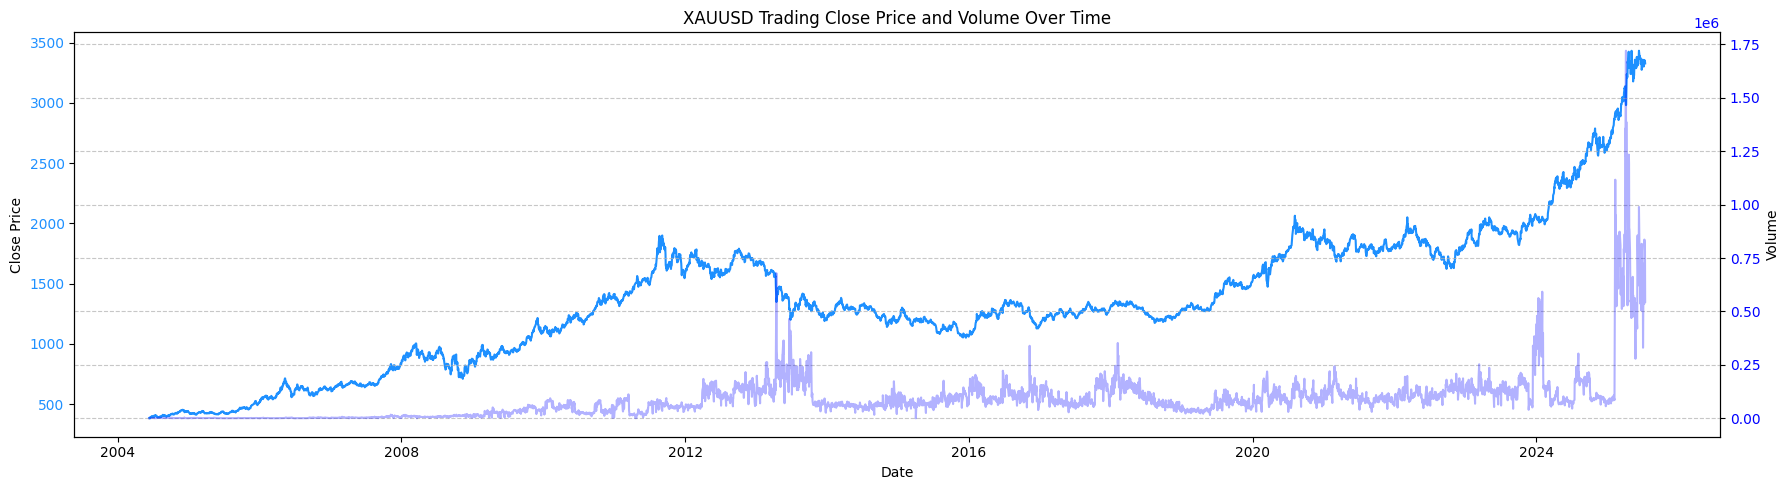

In [33]:
#Close and Volume on two y-axes
plt.figure(figsize=(18,5))

# Create the first y-axis for the close price
ax1 = plt.gca()
ax1.plot(df.index, df['close'], label='close', color='dodgerblue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price')
ax1.tick_params(axis='y', labelcolor='dodgerblue') # Match tick color to line color

# Create the second y-axis for the volume
ax2 = ax1.twinx()
ax2.plot(df.index, df['volume'], label='Volume', color='blue', alpha=0.3)
ax2.set_ylabel('Volume')
ax2.tick_params(axis='y', labelcolor='blue') # Match tick color to line color

plt.title('XAUUSD Trading Close Price and Volume Over Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.2 Trend - Cycle - Sesonal

<Figure size 1400x1000 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


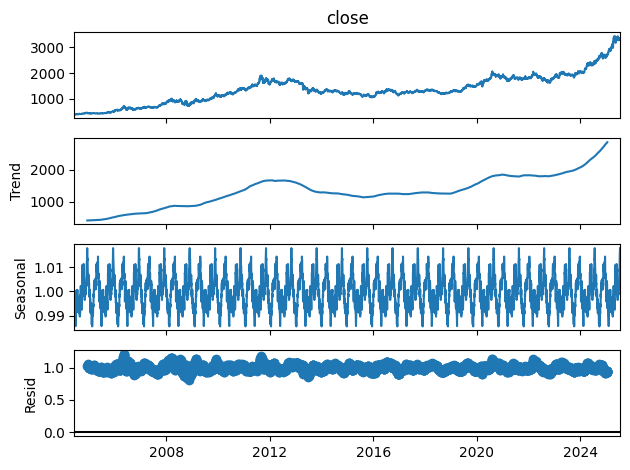

In [36]:
# Decompose the 'close' price series (using the Multiplicative model)
# We assume a periodicity of 252 (number of trading days in a year)
decomposition = seasonal_decompose(df['close'], model='multiplicative', period=252)

# Plot the decomposed components
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

### 3.3 Stationarity Test Results (Augmented Dickey-Fuller)
Augmented Dickey-Fuller (ADF) test to formally check this.
- Null Hypothesis ($H_0$): The time series is non-stationary (it has a unit root).
- Alternative Hypothesis ($H_1$​): The time series is stationary.

In [52]:
def adf_test(series):
    """Performs and prints the results of the ADF test."""
    print("--- Results of Augmented Dickey-Fuller Test ---")
    result = adfuller(series.dropna())

    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")

    if result[1] <= 0.05:
        print("Conclusion: Reject H0. The series is likely stationary.")
    else:
        print("Conclusion: Fail to Reject H0. The series is non-stationary.")

# Run the test on the 'close' price
adf_test(df['close'])

--- Results of Augmented Dickey-Fuller Test ---
ADF Statistic: 1.2942
p-value: 0.9966
Conclusion: Fail to Reject H0. The series is non-stationary.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


- This means the gold (XAUUSD) closing price series is *non-stationary*, showing a trend and possibly *heteroskedasticity*.
- Non-stationarity implies the statistical properties (mean, variance) change over time, unsuitable for direct modeling with ARIMA or similar methods.

=> Hence, we proceed to difference the series to remove the trend.

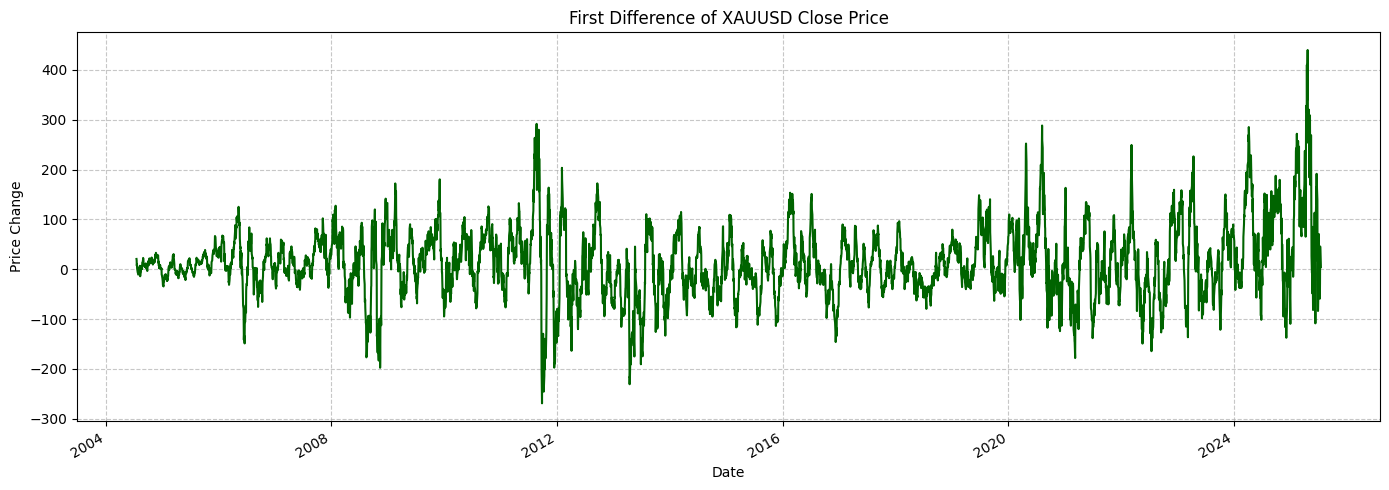

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



--- Testing Stationarity of the DIFFERENCED Series ---
--- Results of Augmented Dickey-Fuller Test ---
ADF Statistic: -8.6957
p-value: 0.0000
Conclusion: Reject H0. The series is likely stationary.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [60]:
# Calculate the first difference of the close price
df['close_diff'] = df['close'].diff(periods=25)

# Plot the differenced series
plt.figure(figsize=(14, 5))
df['close_diff'].plot(title='First Difference of XAUUSD Close Price',
                      color='darkgreen',
                      linewidth=1.5)
plt.xlabel("Date")
plt.ylabel("Price Change")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Test the differenced series for stationarity
print("\n--- Testing Stationarity of the DIFFERENCED Series ---")
adf_test(df['close_diff'])

Differencing removes the long-term trend and stabilizes the mean.

- After differencing, the data now oscillates around zero, suggesting **constant variance** and **mean reversion**.

- This is a key transformation before using ARIMA/ or other forecasting models that require stationarity.

### 3.4 ACF and PACF of Differenced Series

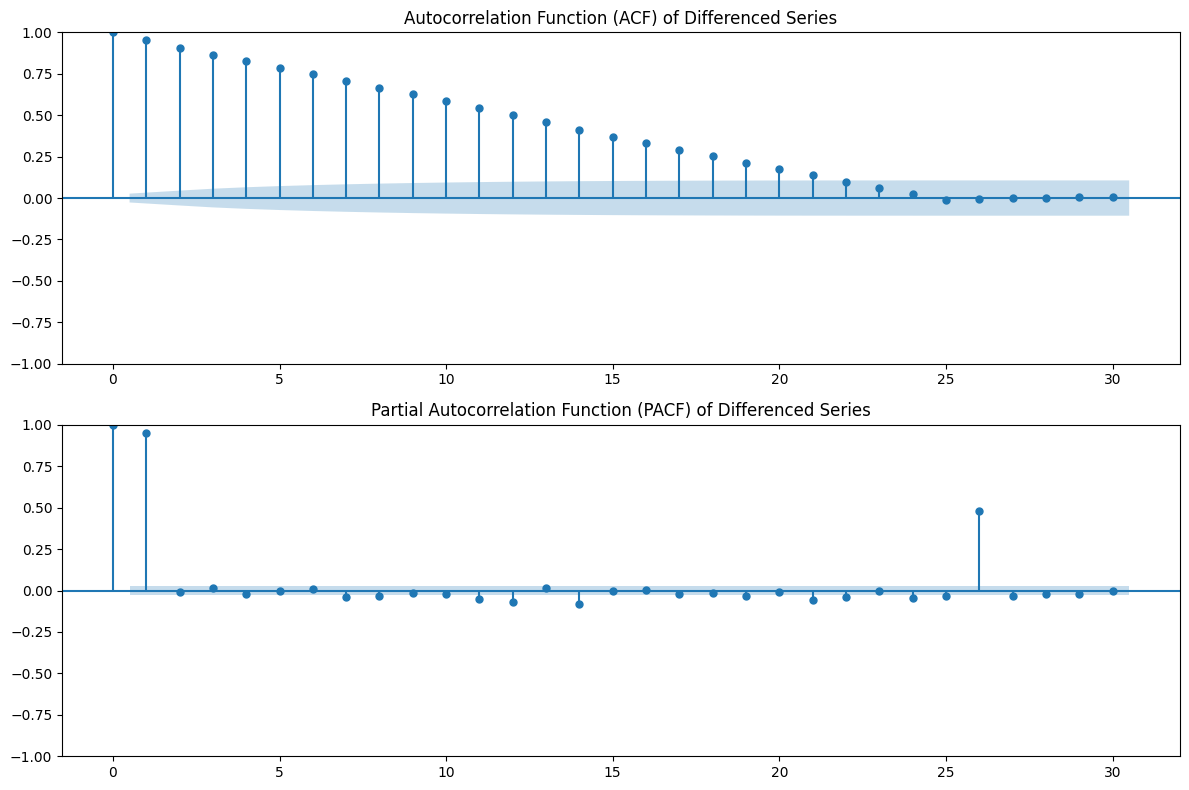

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [61]:
# Ensure you use the stationary series (the first difference)
stationary_series = df['close_diff'].dropna()

# Create plots for ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrelation Function (ACF) plot
plot_acf(stationary_series, lags=30, ax=axes[0], title='Autocorrelation Function (ACF) of Differenced Series')

# Partial Autocorrelation Function (PACF) plot
plot_pacf(stationary_series, lags=30, ax=axes[1], title='Partial Autocorrelation Function (PACF) of Differenced Series')

plt.tight_layout()
plt.show()

**Result:**
The ACF shows a slow, gradual decay while the PACF has a strong spike at lag 1 and quickly drops afterward.

**Explanation:**
- The slow decay in ACF indicates that the series follows an **autoregressive (AR)** process.  
- The sharp cutoff in PACF at lag 1 suggests an **AR(1)** model is appropriate.  
- Because the data was differenced to achieve stationarity, the suitable model is **ARIMA(1,1,0)**


## 4. Forecasting

In [14]:
# Split the data into training and testing sets (80/20)
train_size = int(len(df) * 0.8)
train_data, test_data = df[0:train_size], df[train_size:]


### 4.1. ARIMA Model

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 4334
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -17330.758
Date:                Mon, 27 Oct 2025   AIC                          34665.516
Time:                        04:56:35   BIC                          34678.264
Sample:                             0   HQIC                         34670.016
                               - 4334                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0111      0.010      1.115      0.265      -0.008       0.031
sigma2       174.4598      1.756     99.335      0.000     171.018     177.902
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


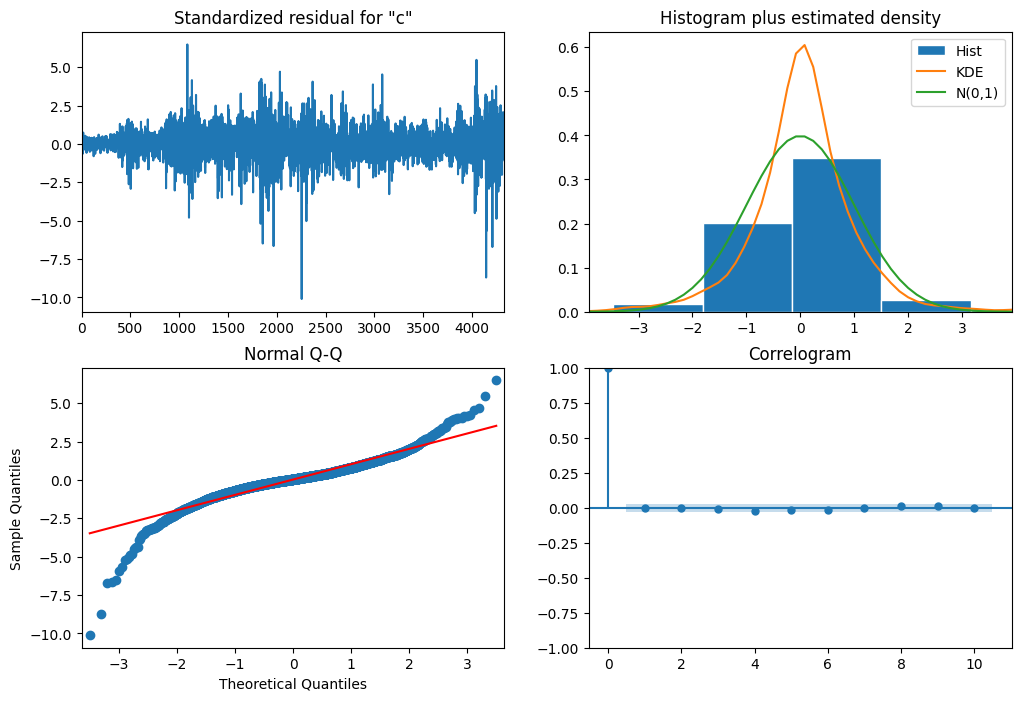

Mean Squared Error (MSE): 339118.0944
Root Mean Squared Error (RMSE): 582.3385
Mean Absolute Error (MAE): 376.3071
R-squared (R2): -0.6295


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [66]:
p, d, q = 1, 1, 0

# Fit the ARIMA model on the training data
model = ARIMA(train_data['close'], order=(p, d, q))
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# Make predictions on the test data
predictions = results.predict(start=len(train_data), end=len(df)-1)

# Ensure predictions align with the test_data index
predictions.index = test_data.index

# Calculate evaluation metrics
mse = mean_squared_error(test_data['close'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['close'], predictions)
r2 = r2_score(test_data['close'], predictions)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

### 4.2 SARIMA Model

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



--- SARIMA Model Metrics ---
Mean Squared Error (MSE): 339913.1371
Root Mean Squared Error (RMSE): 583.0207
Mean Absolute Error (MAE): 377.1070
R-squared (R2): -0.6333

Metrics stored for SARIMA model.
                                     SARIMAX Results                                      
Dep. Variable:                              close   No. Observations:                 4334
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 25)   Log Likelihood              -17330.167
Date:                            Mon, 27 Oct 2025   AIC                          34666.334
Time:                                    05:00:44   BIC                          34685.456
Sample:                                         0   HQIC                         34673.084
                                           - 4334                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025   

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


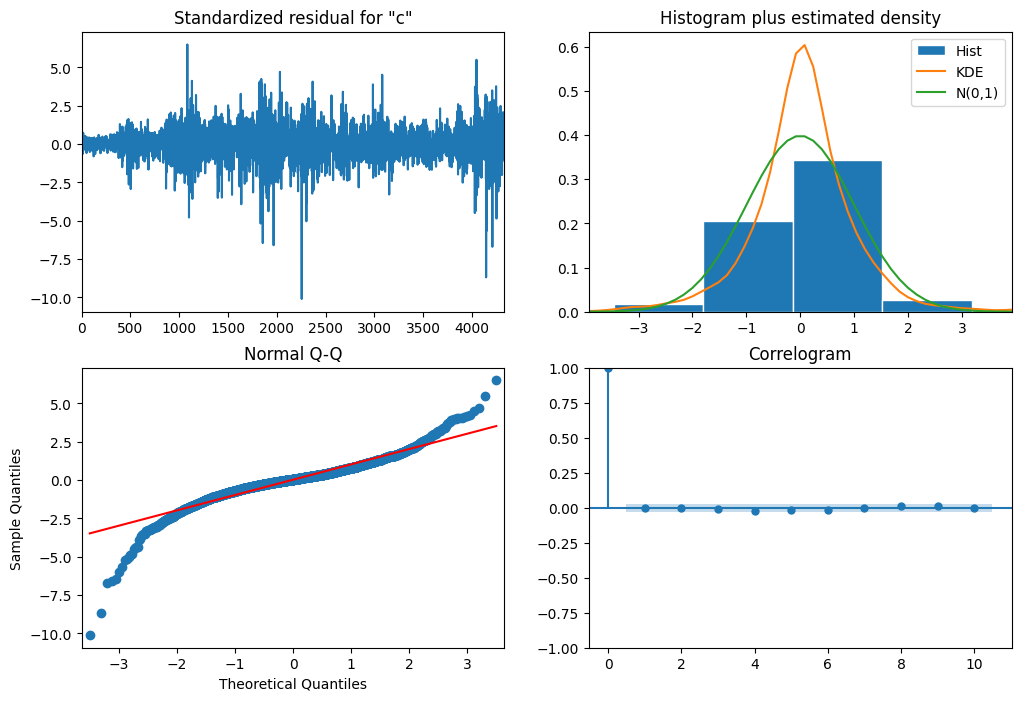

In [75]:
# Define a seasonal order (P, D, Q, s)
# s is the seasonal period. For monthly seasonality in daily data, s=25 (approx trading days).
seasonal_order = (1, 0, 0, 25)
P, D, Q, s = seasonal_order

try:
    # Instantiate the SARIMAX model
    sarima_model = SARIMAX(train_data['close'], order=(p, d, q), seasonal_order=(P, D, Q, s))

    # Fit the model
    sarima_results = sarima_model.fit()

    # Make predictions on the test data period
    sarima_predictions = sarima_results.predict(start=len(train_data), end=len(df)-1)

    # Ensure predictions align with the test_data index
    sarima_predictions.index = test_data.index

    # Calculate evaluation metrics for the SARIMA model
    sarima_mse = mean_squared_error(test_data['close'], sarima_predictions)
    sarima_rmse = np.sqrt(sarima_mse)
    sarima_mae = mean_absolute_error(test_data['close'], sarima_predictions)
    sarima_r2 = r2_score(test_data['close'], sarima_predictions)

    # Print the calculated evaluation metrics for the SARIMA model
    print("\n--- SARIMA Model Metrics ---")
    print(f"Mean Squared Error (MSE): {sarima_mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {sarima_rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {sarima_mae:.4f}")
    print(f"R-squared (R2): {sarima_r2:.4f}")

    # Store the calculated metrics in a dictionary
    sarima_metrics = {
        'MSE': sarima_mse,
        'RMSE': sarima_rmse,
        'MAE': sarima_mae,
        'R2': sarima_r2
    }
    print("\nMetrics stored for SARIMA model.")

except Exception as e:
    print(f"  Error fitting or predicting with SARIMA order ({p}, {d}, {q})x({P}, {D}, {Q}, {s}): {e}")
    sarima_metrics = {} # Store empty dict if error occurs

warnings.filterwarnings("default") # Reset warnings

print(sarima_results.summary())
sarima_results.plot_diagnostics(figsize=(12, 8))
plt.show()


### 4.3 Exponential Smoothing Model



In [79]:
# Choose an appropriate Exponential Smoothing model.
# Given the trend observed in the data but no obvious strong seasonality within a year (252 trading days),
# Holt's linear trend method might be a reasonable starting point, or a simple additive/multiplicative trend.
# Let's try Holt's linear trend method first, which is a form of Exponential Smoothing with trend.
# We set seasonal=None for this initial attempt.

# Instantiate the model
holt_model = ExponentialSmoothing(train_data['close'], trend='add', seasonal=None)

# Fit the model
holt_results = holt_model.fit()

# Make predictions
holt_predictions = holt_results.predict(start=len(train_data), end=len(df)-1)

# Ensure predictions align with the test_data index
holt_predictions.index = test_data.index

# Calculate and print evaluation metrics
holt_mse = mean_squared_error(test_data['close'], holt_predictions)
holt_rmse = np.sqrt(holt_mse)
holt_mae = mean_absolute_error(test_data['close'], holt_predictions)
holt_r2 = r2_score(test_data['close'], holt_predictions)

print("\n--- Exponential Smoothing (Holt's Linear Trend) Model Metrics ---")
print(f"Mean Squared Error (MSE): {holt_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {holt_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {holt_mae:.4f}")
print(f"R-squared (R2): {holt_r2:.4f}")

# Store the calculated metrics (assuming a dictionary `model_metrics` exists or create one)
# For now, let's just store them in a new dictionary for this model.
exponential_smoothing_metrics = {
    'MSE': holt_mse,
    'RMSE': holt_rmse,
    'MAE': holt_mae,
    'R2': holt_r2
}

print("\nMetrics stored for Exponential Smoothing model.")

print(holt_results.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



--- Exponential Smoothing (Holt's Linear Trend) Model Metrics ---
Mean Squared Error (MSE): 175020.2682
Root Mean Squared Error (RMSE): 418.3542
Mean Absolute Error (MAE): 251.8019
R-squared (R2): 0.1590

Metrics stored for Exponential Smoothing model.
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                 4334
Model:             ExponentialSmoothing   SSE                         755478.769
Optimized:                         True   AIC                          22375.171
Trend:                         Additive   BIC                          22400.668
Seasonal:                          None   AICC                         22375.190
Seasonal Periods:                  None   Date:                 Mon, 27 Oct 2025
Box-Cox:                          False   Time:                         05:11:24
Box-Cox Coeff.:                    None                                         
                 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 5. Data Evaluation

--- Model Performance Comparison ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,Model,MSE,RMSE,MAE,R2
0,"ARIMA (1,1,0)",339118.094395,582.338471,376.307138,-0.629507
1,Exponential Smoothing,175020.268220,418.354238,251.801853,0.159005
2,"SARIMA (1,1,0)x(1,0,0,25)",339913.137064,583.020700,377.107015,-0.633327


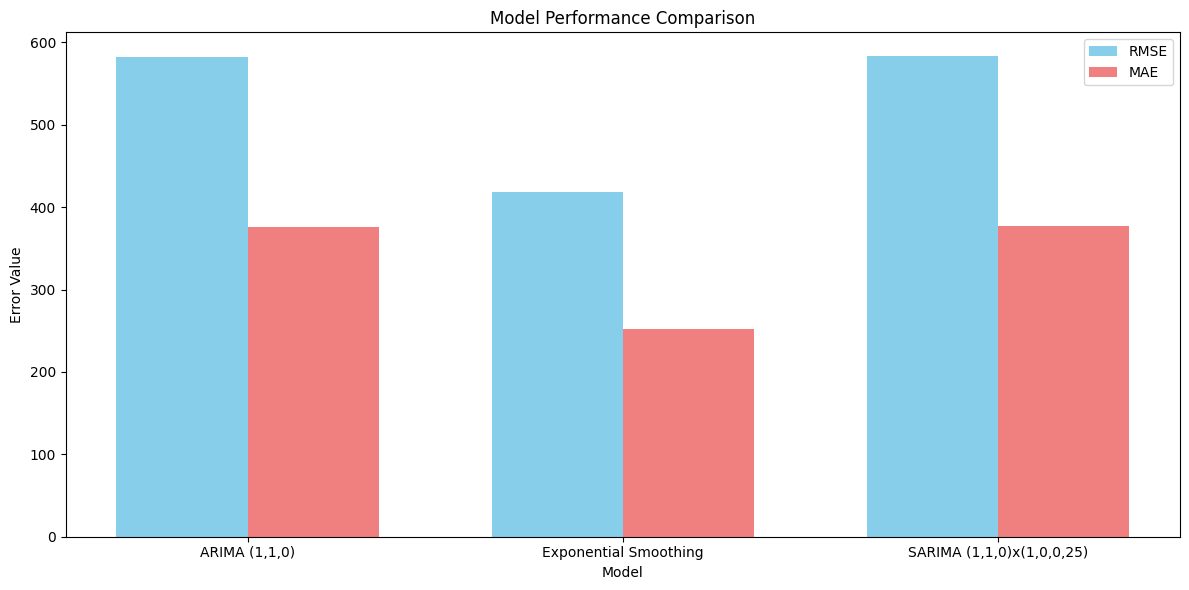

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
comparison_df['MSE'].plot(kind='hist', bins=20, title='MSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_df['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
comparison_df['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_df['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
import seaborn as sns
comparison_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
comparison_df.plot(kind='scatter', x='MSE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
comparison_df.plot(kind='scatter', x='RMSE', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
comparison_df.plot(kind='scatter', x='MAE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
comparison_df['MSE'].plot(kind='line', figsize=(8, 4), title='MSE')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
comparison_df['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
comparison_df['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
comparison_df['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison_df, x='MSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison_df, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison_df, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison_df, x='R2', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [87]:
# We will compare the Initial ARIMA, Exponential Smoothing, and SARIMA models
metrics_data = {
    'Model': ['ARIMA (1,1,0)', 'Exponential Smoothing', 'SARIMA (1,1,0)x(1,0,0,25)'],
    'MSE': [mse, exponential_smoothing_metrics['MSE'], sarima_metrics['MSE']],
    'RMSE': [rmse, exponential_smoothing_metrics['RMSE'], sarima_metrics['RMSE']],
    'MAE': [mae, exponential_smoothing_metrics['MAE'], sarima_metrics['MAE']],
    'R2': [r2, exponential_smoothing_metrics['R2'], sarima_metrics['R2']]
}

# Create the comparison DataFrame
comparison_df = pd.DataFrame(metrics_data)

# Print the comparison DataFrame
print("--- Model Performance Comparison ---")
display(comparison_df)

# Create a bar plot to compare RMSE and MAE
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
index = np.arange(len(comparison_df['Model']))

bar1 = ax.bar(index, comparison_df['RMSE'], bar_width, label='RMSE', color='skyblue')
bar2 = ax.bar(index + bar_width, comparison_df['MAE'], bar_width, label='MAE', color='lightcoral')

ax.set_xlabel('Model')
ax.set_ylabel('Error Value')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()

plt.tight_layout()
plt.show()

## 6. Forecasting

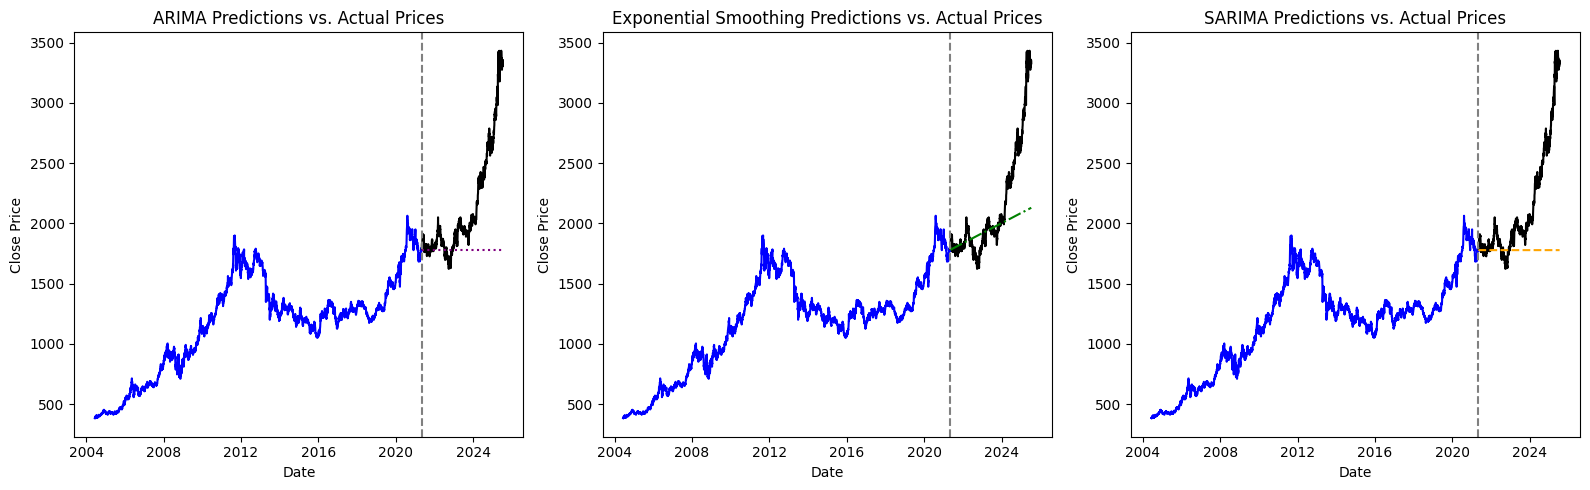

In [88]:
# Create a list of models, their predictions, and labels for plotting
models_to_plot = [
    {'predictions': predictions, 'label': 'ARIMA Predictions', 'color': 'purple', 'linestyle': ':'},
    {'predictions': holt_predictions, 'label': 'Exponential Smoothing Predictions', 'color': 'green', 'linestyle': '-.'},
    {'predictions': sarima_predictions, 'label': 'SARIMA Predictions', 'color': 'orange', 'linestyle': '--'}
]

# Determine the number of rows needed for x columns
n_models = len(models_to_plot)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Plot each model's predictions in a separate subplot
for i, model_info in enumerate(models_to_plot):
    ax = axes[i]

    # Plot actual prices (training and test data)
    ax.plot(train_data['close'].index, train_data['close'], label='Training Data', color='blue')
    ax.plot(test_data['close'].index, test_data['close'], label='Actual Prices (Test Data)', color='black')

    # Plot predictions from the current model
    ax.plot(test_data['close'].index, model_info['predictions'], label=model_info['label'], color=model_info['color'], linestyle=model_info['linestyle'])

    # Add a vertical line at the split point
    split_date = train_data.index[-1]
    ax.axvline(x=split_date, color='gray', linestyle='--', label='Train/Test Split')

    ax.set_title(f"{model_info['label']} vs. Actual Prices")
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()